## Setup

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Dense
from tensorflow.keras.layers import MaxPooling1D, Flatten, Dropout

tf.random.set_seed(42)  # for stable neural network results

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

## Dataset

In [2]:
with open("all_signals.pickle", "rb") as fp:
    all_signals = pickle.load(fp)
    
with open("all_keys.pickle", "rb") as fp:
    all_keys = pickle.load(fp)


le = LabelEncoder()

X_temp, X_train, y_temp, y_train = train_test_split(
    # specifiying a random states seeds the random shuffle, 42 is common as per the scikit docs
    all_signals, le.fit_transform(all_keys), test_size=0.8, random_state=0
)
X_test, X_validate, y_test, y_validate = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

def uniq(data):
    return np.unique(data, return_counts=True)[1]

pd.DataFrame(
    [ uniq(y_train), uniq(y_test), uniq(y_validate) ],
    [ "Training Set", "Testing Set", "Validation Set" ],
    le.classes_,
)

,Coronary artery disease,Healthy control
Training Set,5931,6703
Testing Set,741,838
Validation Set,762,817


## Model

In [3]:
input_shape = (X_train.shape[1], 1)

model = tf.keras.Sequential([
    Conv1D(filters=3, kernel_size=20, activation='relu', input_shape=input_shape),
    MaxPooling1D(2, strides=2),
    
    Conv1D(filters=6, kernel_size=10, activation='relu'),
    MaxPooling1D(2, strides=2),
    
    Conv1D(filters=9, kernel_size=5, activation='relu'),
    MaxPooling1D(2, strides=2),
    
    Flatten(),
    Dense(20, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='relu'),
    Dropout(0.2),
        Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')  
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

model.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_validate, y_validate)
)

evaluation = model.evaluate(X_test, y_test, verbose=2)
print("Loss (Test Set)", evaluation[0])
print("Accuracy (Test Set)", evaluation[1])

model.summary()

Epoch 1/10
395/395 [==============================] - 11s 25ms/step - loss: 0.3129 - accuracy: 0.8730 - val_loss: 0.2598 - val_accuracy: 0.9088
Epoch 2/10
395/395 [==============================] - 8s 19ms/step - loss: 0.2369 - accuracy: 0.9215 - val_loss: 0.2167 - val_accuracy: 0.9183
Epoch 3/10
395/395 [==============================] - 16s 41ms/step - loss: 0.2116 - accuracy: 0.9269 - val_loss: 0.1966 - val_accuracy: 0.9234
Epoch 4/10
395/395 [==============================] - 12s 30ms/step - loss: 0.1821 - accuracy: 0.9325 - val_loss: 0.1836 - val_accuracy: 0.9316
Epoch 5/10
395/395 [==============================] - 12s 31ms/step - loss: 0.1654 - accuracy: 0.9389 - val_loss: 0.1711 - val_accuracy: 0.9335
Epoch 6/10
395/395 [==============================] - 20s 50ms/step - loss: 0.1560 - accuracy: 0.9445 - val_loss: 0.1608 - val_accuracy: 0.9335
Epoch 7/10
395/395 [==============================] - 11s 29ms/step - loss: 0.1428 - accuracy: 0.9487 - val_loss: 0.1486 - val_accuracy: 

## Results

50/50 [==============================] - 0s 6ms/step


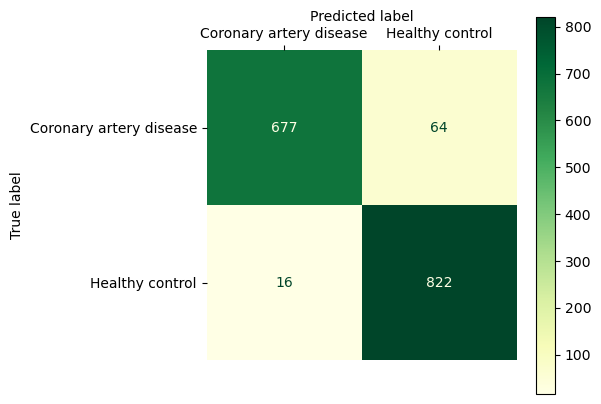

In [4]:
predictions = model.predict(X_test)
predictions = np.rint(predictions).astype(int)

cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)

# move horizontal axis to top
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
ax.xaxis.set_label_position('top') 

# turn off spines
ax.spines[:].set_visible(False)

disp.plot(cmap="YlGn", colorbar=True, ax=ax)